In [1]:
import warnings 
warnings.filterwarnings('ignore') # feel free to comment this out if you want to see warnings 

import csv 
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, Flatten


from statsmodels.tools.eval_measures import rmse

import numpy as np


Using TensorFlow backend.


In [2]:
mers = pd.read_csv('../data/mers-outbreak-dataset-20122019/weekly_clean.csv')


In [3]:
mers.head(15)

,Year,Week,Region,New Cases
0,2012,12,Other Countries,1
1,2012,12,Republic of Korea,0
2,2012,12,Saudi Arabia,0
3,2012,13,Other Countries,0
4,2012,13,Republic of Korea,0
5,2012,13,Saudi Arabia,0
6,2012,14,Other Countries,1
7,2012,14,Republic of Korea,0
8,2012,14,Saudi Arabia,0
9,2012,15,Other Countries,0


What countries were impacted with mers? 

In [4]:
countries = list(mers["Region"].unique())
countries

['Other Countries', 'Republic of Korea', 'Saudi Arabia']

In [5]:
other = mers.loc[mers["Region"] == "Other Countries"]
other = other.reset_index(drop=True)

korea = mers.loc[mers["Region"] == "Republic of Korea"]
korea = korea.reset_index(drop=True)

sa = mers.loc[mers["Region"] == "Saudi Arabia"]
sa = sa.reset_index(drop=True)

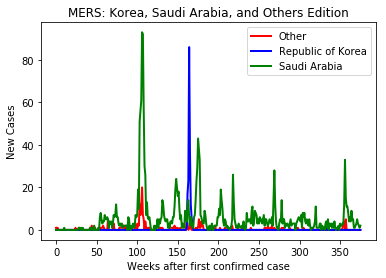

In [6]:
plt.plot(other.index, other['New Cases'], 'r', linewidth = 2, label="Other")
plt.plot(korea.index, korea['New Cases'],'b',linewidth = 2, label="Republic of Korea")
plt.plot(sa.index, sa['New Cases'],'g',linewidth = 2, label="Saudi Arabia")
plt.title("MERS: Korea, Saudi Arabia, and Others Edition")
plt.xlabel("Weeks after first confirmed case")
plt.ylabel("New Cases")
plt.legend()
plt.show()

In [7]:
sa.Year = pd.to_datetime(sa.Year.astype(str), format='%Y') + \
             pd.to_timedelta(sa.Week.mul(7).astype(str) + ' days')
             
korea.Year = pd.to_datetime(korea.Year.astype(str), format='%Y') + \
             pd.to_timedelta(korea.Week.mul(7).astype(str) + ' days')

other.Year = pd.to_datetime(other.Year.astype(str), format='%Y') + \
             pd.to_timedelta(other.Week.mul(7).astype(str) + ' days')
             

sa = sa.drop(["Week"],axis=1)
korea = korea.drop(["Week"],axis=1)
other = other.drop(["Week"],axis=1)

sa = sa.drop(["Region"],axis=1)
korea = korea.drop(["Region"],axis=1)
other = other.drop(["Region"],axis=1)

sa = sa.set_index("Year")
korea = korea.set_index("Year")
other = other.set_index("Year")


train_data_sa = sa[:len(sa)-75]
test_data_sa = sa[len(sa)-75:]
train_data_korea = korea[:len(korea)-75]
test_data_korea = korea[len(korea)-75:]
train_data_other = other[:len(other)-75]
test_data_other = other[len(other)-75:]


In [8]:
scaler = MinMaxScaler()
scaler.fit(train_data_sa)
scaled_train_data = scaler.transform(train_data_sa)
scaled_test_data = scaler.transform(test_data_sa)

n_input = 7
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)


lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

lstm_model.fit_generator(generator,epochs=20)


Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
294/294 [==============================] - 4s 14ms/step - loss: 0.0104
Epoch 2/20
294/294 [==============================] - 3s 9ms/step - loss: 0.0085
Epoch 3/20
294/294 [==============================] - 3s 9ms/step - loss: 0.0065
Epoch 4/20
294/294 [==============================] - 2s 8ms/step - loss: 0.0070
Epoch 5/20
294/294 [==============================] - 2s 8ms/step

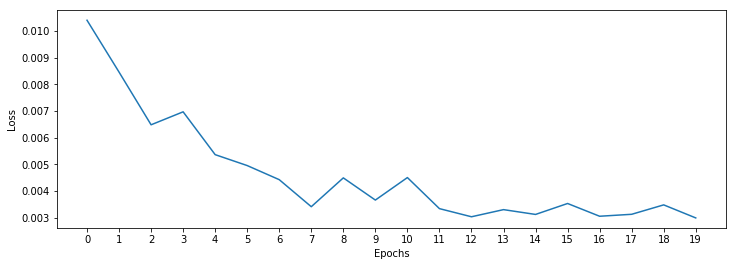

In [9]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);




In [10]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data_sa)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

lstm_predictions_scaled

[array([0.0802161], dtype=float32),
 array([0.08413479], dtype=float32),
 array([0.08494452], dtype=float32),
 array([0.08381815], dtype=float32),
 array([0.08118621], dtype=float32),
 array([0.0751201], dtype=float32),
 array([0.0647444], dtype=float32),
 array([0.05735666], dtype=float32),
 array([0.05251136], dtype=float32),
 array([0.0493799], dtype=float32),
 array([0.04785894], dtype=float32),
 array([0.04807957], dtype=float32),
 array([0.04999079], dtype=float32),
 array([0.05310396], dtype=float32),
 array([0.05679394], dtype=float32),
 array([0.06089997], dtype=float32),
 array([0.06483337], dtype=float32),
 array([0.06799123], dtype=float32),
 array([0.06987397], dtype=float32),
 array([0.07024631], dtype=float32),
 array([0.06900673], dtype=float32),
 array([0.06641214], dtype=float32),
 array([0.06303242], dtype=float32),
 array([0.05961585], dtype=float32),
 array([0.05670961], dtype=float32),
 array([0.05462388], dtype=float32),
 array([0.05352303], dtype=float32),
 arra

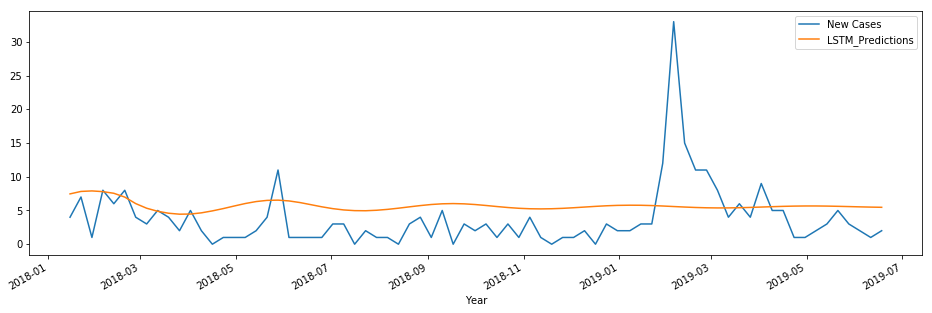

In [11]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

lstm_predictions

test_data_sa['LSTM_Predictions'] = lstm_predictions
test_data_sa


test_data_sa['New Cases'].plot(figsize = (16,5), legend=True)
test_data_sa['LSTM_Predictions'].plot(legend = True);


In [12]:
lstm_rmse_error_sa = rmse(test_data_sa['New Cases'], test_data_sa["LSTM_Predictions"])
lstm_mse_error_sa = lstm_rmse_error_sa**2
mean_value = sa['New Cases'].mean()

In [13]:
scaler = MinMaxScaler()
scaler.fit(train_data_korea)
scaled_train_data = scaler.transform(train_data_korea)
scaled_test_data = scaler.transform(test_data_korea)

n_input = 7
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)


lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

lstm_model.fit_generator(generator,epochs=20)



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
294/294 [==============================] - 3s 11ms/step - loss: 0.0044
Epoch 2/20
294/294 [==============================] - 4s 14ms/step - loss: 0.0039
Epoch 3/20
294/294 [==============================] - 4s 13ms/step - loss: 0.0038
Epoch 4/20
294/294 [==============================] - 4s 14ms/step - loss: 0.0035
Epoch 5/20
294/294 [==============================] - 3s 10ms/step - loss: 0.0033
Epoch 6/20
294/294 [==============================] - 3s 11ms/step - loss: 0.0031
Epoch 7/20
294/294

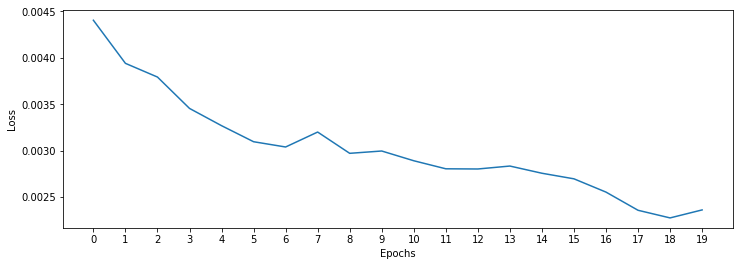

In [14]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);




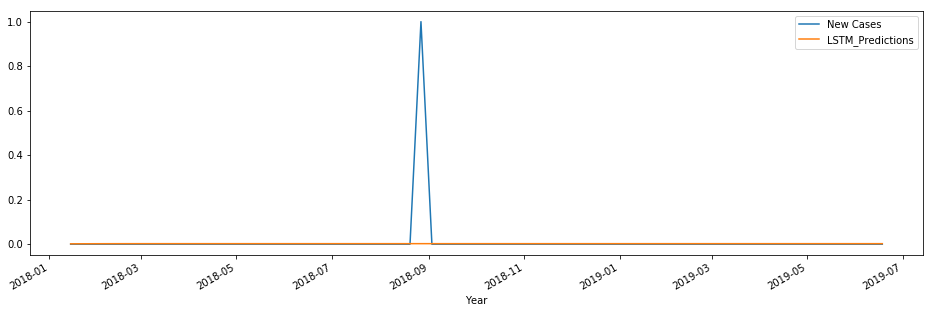

In [15]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data_korea)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

lstm_predictions_scaled

lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

lstm_predictions

test_data_korea['LSTM_Predictions'] = lstm_predictions
test_data_korea


test_data_korea['New Cases'].plot(figsize = (16,5), legend=True)
test_data_korea['LSTM_Predictions'].plot(legend = True);

In [16]:

lstm_rmse_error_korea = rmse(test_data_korea['New Cases'], test_data_korea["LSTM_Predictions"])
lstm_mse_error_korea = lstm_rmse_error_korea**2
mean_value = korea['New Cases'].mean()

In [17]:
scaler = MinMaxScaler()
scaler.fit(train_data_other)
scaled_train_data = scaler.transform(train_data_other)
scaled_test_data = scaler.transform(test_data_other)



 

n_input = 7
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)


lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

lstm_model.fit_generator(generator,epochs=20)




Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
294/294 [==============================] - 3s 11ms/step - loss: 0.0077
Epoch 2/20
294/294 [==============================] - 2s 8ms/step - loss: 0.0069
Epoch 3/20
294/294 [==============================] - 3s 9ms/step - loss: 0.0064
Epoch 4/20
294/294 [==============================] - 3s 9ms/step - loss: 0.0058
Epoch 5/20
294/294 [==============================] - 3s 11ms/step - loss: 0.0059
Epoch 6/20
294/294 [==============================] - 3s 9ms/step - loss: 0.0051
Epoch 7/20
294/294 [==

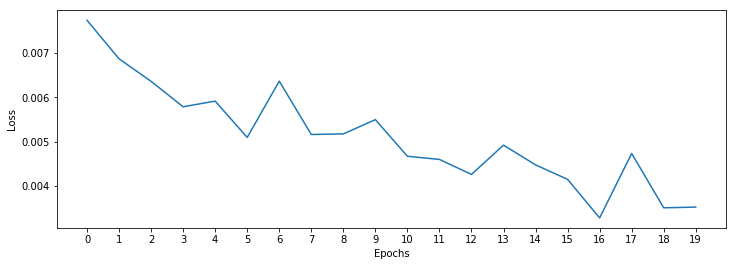

In [18]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);




In [19]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data_other)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

lstm_predictions_scaled

lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

lstm_predictions




array([[0.47551729],
       [0.48028916],
       [0.483432  ],
       [0.47157239],
       [0.47512606],
       [0.46357963],
       [0.46867199],
       [0.47456741],
       [0.47457676],
       [0.47447369],
       [0.47430228],
       [0.47436349],
       [0.47433071],
       [0.47449477],
       [0.47459185],
       [0.47459207],
       [0.47459159],
       [0.47459289],
       [0.47459744],
       [0.47460072],
       [0.47460496],
       [0.47460675],
       [0.47460698],
       [0.47460716],
       [0.47460742],
       [0.47460765],
       [0.4746078 ],
       [0.47460791],
       [0.47460794],
       [0.47460798],
       [0.47460798],
       [0.47460798],
       [0.47460802],
       [0.47460802],
       [0.47460802],
       [0.47460802],
       [0.47460802],
       [0.47460802],
       [0.47460802],
       [0.47460802],
       [0.47460802],
       [0.47460802],
       [0.47460802],
       [0.47460802],
       [0.47460802],
       [0.47460802],
       [0.47460802],
       [0.474

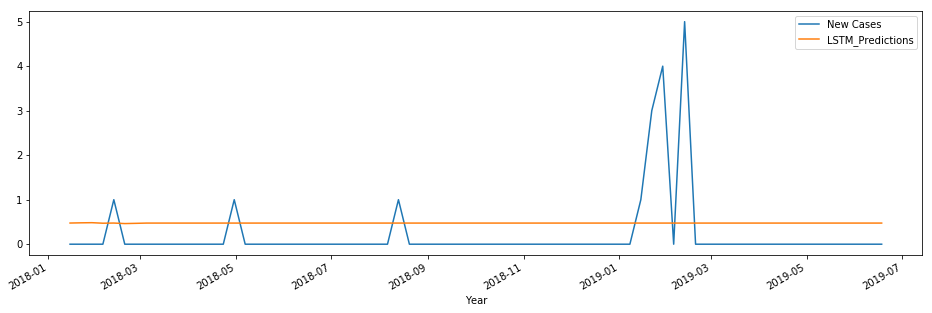

In [20]:
test_data_other['LSTM_Predictions'] = lstm_predictions
test_data_other


test_data_other['New Cases'].plot(figsize = (16,5), legend=True)
test_data_other['LSTM_Predictions'].plot(legend = True);

In [21]:
lstm_rmse_error_other = rmse(test_data_other['New Cases'], test_data_other["LSTM_Predictions"])
lstm_mse_error_other = lstm_rmse_error_other**2
mean_value = other['New Cases'].mean()

In [22]:
from tabulate import tabulate

print(tabulate([
    ['Korea LSTM Errors', lstm_mse_error_korea, lstm_rmse_error_korea], 
    ['Saudi Arabia LSTM Errors', lstm_mse_error_sa, lstm_rmse_error_sa],
    ['Other LSTM Errors', lstm_mse_error_other, lstm_rmse_error_other]], 
    
    headers=['Model', 'MSE', "RMSE", "Mean"]))




Model                            MSE      RMSE
------------------------  ----------  --------
Korea LSTM Errors          0.0132744  0.115215
Saudi Arabia LSTM Errors  24.5149     4.95126
Other LSTM Errors          0.742677   0.861787
